# QAA Pulser

In [14]:
import numpy as np
import json

import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import networkx as nx
from collections import defaultdict

from pulser import Pulse, Sequence, Register
from pulser.waveforms import CompositeWaveform, ConstantWaveform, RampWaveform, InterpolatedWaveform
from pulser.devices import AnalogDevice, DigitalAnalogDevice

from pulser_simulation import SimConfig, QutipEmulator

from pulser.json.abstract_repr.deserializer import deserialize_device

from pasqal_cloud import SDK
import os

In [3]:
class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, ( np.int64)):
            return int(obj)      
        return json.JSONEncoder.default(self, obj)

### Initialize the cloud client 

In [4]:
project_id = ""
username = ""
password = ""


# # Initialize the cloud client
# sdk = SDK(username=username, project_id=project_id,password=password)

# specs = sdk.get_device_specs_dict()
# device = deserialize_device(specs["FRESNEL"])

device_emu = AnalogDevice

In [5]:
def cost_function(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] + x[j] == "11":
            obj += 2
    return - x.count("1") + obj

In [6]:
backends = {}
# backends["pasqal_fresnel"] = device
backends["pulser_emulator"] = device_emu

In [9]:
# Prepare Pulse (Independent of the problem size)

method = "QAA"

t_tot = 4000

t_rise = {1000:450,2000:760,3000:1100,4000:1420}[t_tot]
t_fall = t_rise
t_sweep = t_tot - t_rise - t_fall

Omega_s = 5.5
Delta_i = -5.5
Delta_f = 5.5

rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_s), Delta_i, 0.0
)
sweep = Pulse.ConstantAmplitude(
    Omega_s, RampWaveform(t_sweep, Delta_i, Delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_s, 0.0), Delta_f, 0.0
)

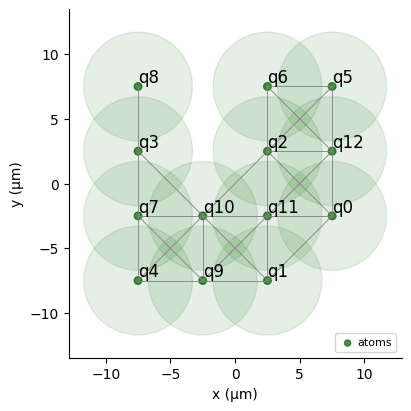

In [10]:
# Prepare Register

nq =  13 # 11, 13, 17,21,25,30,34,41,44,54,56 (in device can do up to 85)
with open(f"./Data/Problems/{nq}.json", "r") as file:
    problem = json.load(file)

G = nx.Graph()
G.add_nodes_from(range(nq))
G.add_edges_from(problem["edges"])
problem.keys()
a = 5.
grid_side = problem["grid_side"]
pos = problem["pos"]
numx,numy = [grid_side,grid_side]
x_shift = a * (numx - 1) / 2
y_shift = a * (numy - 1) / 2
pos_dict = {}
for i, pos_i in enumerate(pos):
    pos_dict[f"q{i}"] = [round(pos_i[0] * a - x_shift,8), round(pos_i[1] * a - y_shift,8)]

register = Register(pos_dict)

register.draw(with_labels=True,
          blockade_radius=2**(3/4)*a,
          draw_graph=True,
          draw_half_radius=True,
          qubit_colors={},
          fig_name=None,
          kwargs_savefig={},
          custom_ax=None,
          show=True)

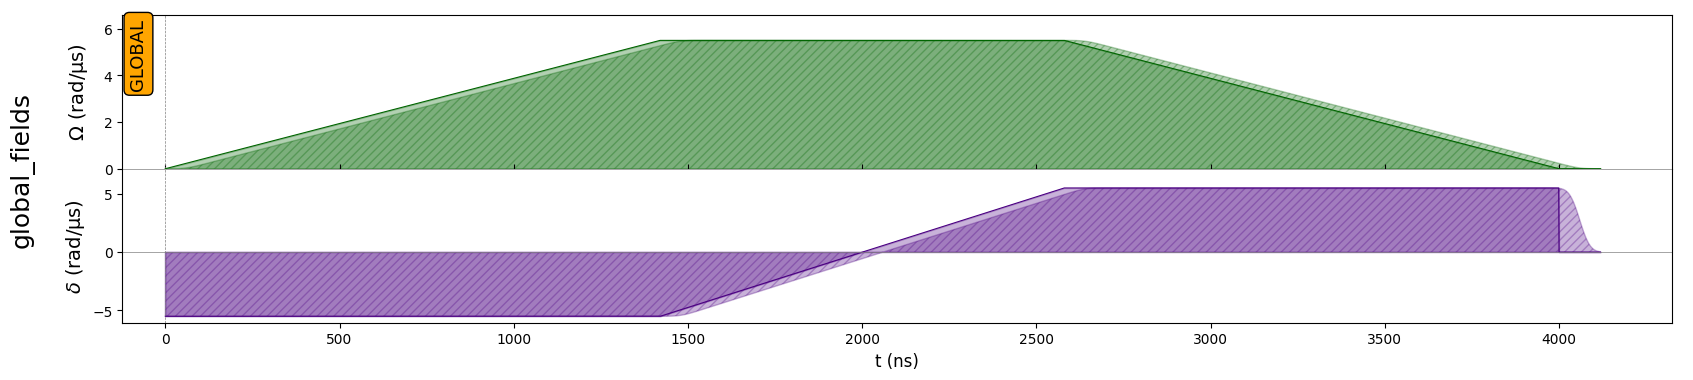

In [15]:
# Run experiment

shots = 500
case = 1
result = {}
backend_name = ["pulser_emulator", "pulser_emulator_noisy", "pasqal_fresnel"][0]

if backend_name == "pasqal_fresnel":
    register = register.with_automatic_layout(backends[backend_name])

sequence = Sequence(register, backends[backend_name])
sequence.declare_channel('global_fields', 'rydberg_global')
sequence.add(rise, "global_fields")
sequence.add(sweep, "global_fields")
sequence.add(fall, "global_fields")
sequence.draw()

if backend_name == "pulser_emulator":
    config = SimConfig()
if backend_name == "pulser_emulator_noisy":
    config = SimConfig(noise=("SPAM"), eta=0.02,epsilon=0.01,epsilon_prime=0.08,runs=30, samples_per_run=5)

if backend_name in ["pulser_emulator", "pulser_emulator_noisy"]:
    emu = QutipEmulator.from_sequence(sequence, sampling_rate = 0.05, evaluation_times=0.1,config=config).run()
    #job = QutipBackend(sequence, config = config).run()
    result["samples"] = emu.sample_final_state(N_samples=shots)
    os.makedirs(f"./Data/{backend_name}/{method}/{case}/", exist_ok=True)
    with open(f"./Data/{backend_name}/{method}/{case}/{nq}_t_{round(t_tot*1e-9,6)}.json", "w") as file:
        json.dump(result,file,cls=NumpyEncoder)
if backend_name == "pasqal_fresnel":
    serialized_sequence = sequence.to_abstract_repr()
    job = {"job_ID":f"nq{nq}","runs": shots}
    batch = sdk.create_batch(serialized_sequence, [job]#, emulator=EmulatorType.EMU_FREE
                            )

In [16]:
# Postprocessing

nq = 13
backend_name = ["pulser_emulator", "pulser_emulator_noisy", "pasqal_fresnel"][0]
with open(f"./Data/{backend_name}/{method}/{case}/{nq}_t_{round(t_tot*1e-9,6)}.json", "r") as file:
    result = json.load(file)
if backend_name == "pasqal_fresnel":
    batch_id = list(result.keys())[0]
    result = result[batch_id]
    result['samples'] = result.pop('counter')
    

with open(f"./Data/problems/{nq}.json", "r") as file:
    problem = json.load(file)
G = nx.Graph()
G.add_nodes_from(range(nq))
G.add_edges_from(problem["edges"])

cost_evals = defaultdict(int)
for k, v in result["samples"].items():
    cost = cost_function(k, G)
    cost_evals[cost] += v
result["cost"] = cost_evals 
result["min_cost"] = cost_function(problem["sol"], G)

with open(f"./Data/{backend_name}/{method}/{case}/{nq}_t_{round(t_tot*1e-9,6)}.json", "w") as file:
    json.dump(result, file)